In [3]:
import pandas as pd
import numpy as np
from numpy.lib.format import open_memmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

### Imports

### Generate Data

In [2]:
def initialize_sample_memmap_npy():
    ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id': str, 'timepoint': int})

    feature_cols = ref.columns[2:]
    # Scale data with Pareto scaling
    feat_df = ref[feature_cols].astype(float)
    feat_df = feat_df.div(np.sqrt(feat_df.std()), axis=1)
    feat_df = feat_df.div(feat_df.sum(axis=1), axis=0)

    # Replace NA's with 0
    feat_df = feat_df.fillna(0.0)

    # Build lookup on scaled vectors
    sample_dict = {
        (row['patient_id'].lstrip('0'), row['timepoint']): 
           feat_df.iloc[i].to_numpy(dtype=np.float32)
        for i, row in ref.iterrows()
    }

    for split in ('train','val','test'):
        pairs = pd.read_csv(f'data/{split}_pair_keys.csv',
                            dtype={'patient_id_a':str,'timepoint_a':int,
                                   'patient_id_b':str,'timepoint_b':int})
        n = len(pairs)
        feature_dim = len(feature_cols)

        X_mm = open_memmap(f'data/{split}_scaled_X.npy', mode='w+', dtype='float32',
                           shape=(n, feature_dim))
        y_mm = open_memmap(f'data/{split}_scaled_y.npy', mode='w+', dtype='int8',
                           shape=(n,))

        for i, row in enumerate(pairs.itertuples(index=False)):
            a, ta = row.patient_id_a.lstrip('0'), row.timepoint_a
            b, tb = row.patient_id_b.lstrip('0'), row.timepoint_b
            vec_a = sample_dict[(a, ta)]
            vec_b = sample_dict[(b, tb)]
            X_mm[i] = np.abs(vec_a - vec_b)
            y_mm[i] = 1 if a == b else 0

        X_mm.flush(); y_mm.flush()
        print(f"{split} data built: {X_mm.shape}")

initialize_sample_memmap_npy()

train data built: (26106, 40921)
val data built: (11935, 40921)
test data built: (8629, 40921)


### Load Data

In [3]:
# Load key files to get sizes and feature dimension
ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id':str,'timepoint':int})
feature_dim = ref.shape[1] - 2

train_pairs = pd.read_csv('data/train_pair_keys.csv', dtype={'patient_id_a':str,'timepoint_a':int,'patient_id_b':str,'timepoint_b':int})
val_pairs   = pd.read_csv('data/val_pair_keys.csv',   dtype=train_pairs.dtypes.to_dict())
test_pairs  = pd.read_csv('data/test_pair_keys.csv',  dtype=train_pairs.dtypes.to_dict())

n_train = len(train_pairs)
n_val   = len(val_pairs)
n_test  = len(test_pairs)

# Memory-map the data
train_X = np.load('data/train_scaled_X.npy', mmap_mode='r')
train_y = np.load('data/train_scaled_y.npy', mmap_mode='r')
val_X   = np.load('data/val_scaled_X.npy',   mmap_mode='r')
val_y   = np.load('data/val_scaled_y.npy',   mmap_mode='r')
test_X  = np.load('data/test_scaled_X.npy',  mmap_mode='r')
test_y  = np.load('data/test_scaled_y.npy',  mmap_mode='r')

In [13]:
# count the number of positive and negative samples
pos_count = np.sum(train_y)
neg_count = n_train - pos_count
print(f"Train set: {n_train} samples, {pos_count} positives, {neg_count} negatives")

# validation set
val_pos_count = np.sum(val_y)
val_neg_count = n_val - val_pos_count
print(f"Validation set: {n_val} samples, {val_pos_count} positives, {val_neg_count} negatives")

# test set
test_pos_count = np.sum(test_y)
test_neg_count = n_test - test_pos_count
print(f"Test set: {n_test} samples, {test_pos_count} positives, {test_neg_count} negatives")

Train set: 26106 samples, 624 positives, 25482 negatives
Validation set: 11935 samples, 189 positives, 11746 negatives
Test set: 8629 samples, 111 positives, 8518 negatives


### Train Model

In [62]:
# Logistic Regression model
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10
)
classes    = np.unique(train_y)

# Mini‐batch training
# cross validation implemented with sklearn cross_val_score
from sklearn.model_selection import StratifiedKFold
negative_weight = 0.05
positive_weight = 2.0
print(f"Negative weight: {negative_weight:.4f}, Positive weight: {positive_weight:.4f}")
sample_weight = np.where(train_y == 1, positive_weight, negative_weight)
clf.fit(train_X, train_y, sample_weight=sample_weight)


for name, X, y in [('Train', train_X, train_y),
                  ('Val',   val_X,   val_y),
                  ('Test',  test_X,  test_y)]:
    pred = clf.predict(X)
    acc   = accuracy_score(y, pred)
    recall = np.sum((y == 1) & (pred == 1)) / np.sum(y == 1)
    precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)
    fpr = np.sum((y == 0) & (pred == 1)) / np.sum(y == 0)
    f1    = f1_score(y, pred, average='weighted')
    print(f"{name:5} → Acc: {acc:.4f}, F1: {f1:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, fpr: {fpr:.4f}")

Negative weight: 0.0500, Positive weight: 2.0000
Train → Acc: 0.9966, F1: 0.9967, recall: 1.0000, precision: 0.8739, fpr: 0.0035
Val   → Acc: 0.9994, F1: 0.9994, recall: 0.9630, precision: 1.0000, fpr: 0.0000
Test  → Acc: 0.9947, F1: 0.9951, recall: 0.9910, precision: 0.7097, fpr: 0.0053


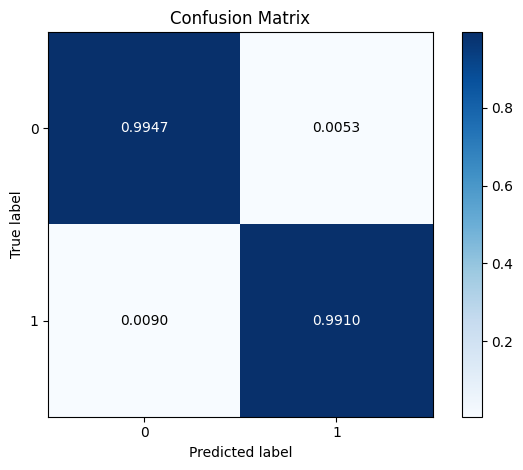

In [66]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches       


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm.astype('int')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, f'{cm[i, j]:.4f}', ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()
plot_confusion_matrix(test_y, pred, classes=classes, normalize=True)

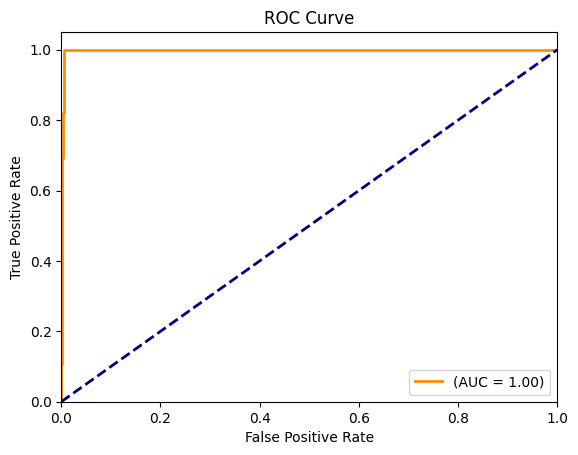

In [72]:
# plot AUC ROC curve
from sklearn.metrics import roc_curve, auc

y_pred_prob = clf.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Inspect features

In [64]:
# View top peptidoform features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(feature_dim)[:20]:
    print(f"Features {indices[f]:2d}:  {importances[indices[f]]:.4f}")

Feature ranking:
Features 116:  0.0138
Features 2348:  0.0112
Features 340:  0.0108
Features 1232:  0.0094
Features 4748:  0.0084
Features 1704:  0.0084
Features 3052:  0.0080
Features 1251:  0.0080
Features 23:  0.0074
Features 3600:  0.0072
Features 1633:  0.0072
Features 1521:  0.0071
Features 1049:  0.0070
Features 27:  0.0070
Features 1573:  0.0068
Features 2640:  0.0067
Features 2561:  0.0066
Features 1694:  0.0063
Features 810:  0.0062
Features 1274:  0.0062


In [4]:
# check the correlation of the features with the target
# check the correlation of the features with the target from y_train, y_val, y_test

train_X_df = pd.DataFrame(train_X[:, [116, 2348, 340, 1232, 4748, 1704, 3052, 1251, 23, 3600]])
train_y_df = pd.DataFrame(train_y, columns=['target'])
train_df = pd.concat([train_X_df, train_y_df], axis=1)
corr = train_df.corr()

In [5]:
corr

,0,1,2,3,4,5,6,7,8,9,target
0,1.000000,0.089943,0.026608,-0.005702,0.058556,0.108322,0.074413,0.037933,0.074280,0.070530,-0.164344
1,0.089943,1.000000,0.063948,0.088273,-0.030820,0.056165,0.283416,0.026412,-0.031105,0.047553,-0.102810
2,0.026608,0.063948,1.000000,0.119235,-0.015827,0.045524,0.073952,0.014802,-0.016688,-0.009047,-0.169123
3,-0.005702,0.088273,0.119235,1.000000,0.005345,0.000698,0.031721,0.018094,-0.051651,-0.026979,-0.158404
4,0.058556,-0.030820,-0.015827,0.005345,1.000000,0.032487,0.027845,0.003646,-0.050438,0.009859,-0.133582
5,0.108322,0.056165,0.045524,0.000698,0.032487,1.000000,0.111271,0.021020,0.101797,0.041547,-0.170121
6,0.074413,0.283416,0.073952,0.031721,0.027845,0.111271,1.000000,-0.024752,-0.063256,0.126046,-0.135308
7,0.037933,0.026412,0.014802,0.018094,0.003646,0.021020,-0.024752,1.000000,-0.015189,-0.024251,-0.142192
8,0.074280,-0.031105,-0.016688,-0.051651,-0.050438,0.101797,-0.063256,-0.015189,1.000000,-0.065726,-0.086588
9,0.070530,0.047553,-0.009047,-0.026979,0.009859,0.041547,0.126046,-0.024251,-0.065726,1.000000,-0.139867


In [73]:
# show the peptidoform features
df = pd.read_csv('data/filtered_results.tsv', sep='\t')
df.iloc[indices[:20], :].to_csv('data/top_peptidoform_features.tsv', sep='\t', index=False)

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_36978/1758957761.py:2: DtypeWarning: Columns (40,44,46,50,54,58,94,100,104,110,118,124,126,128,130,132,134,136,140,142,146,148,150,152,154,156,158,178,186,192,198,202,214,218,230,236,238,240,244,246,248,250,252,254,256,258,260,262,264,266,270,272,274,276,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,324,326,332,334,336,338,340,342,344,346,348,352,366,374,376,380,382,384,390,392,394,396,400,406,408,410,412,414,416,418,428,430,442,446,448,456,460,462,466,468,470,486,504,512,516,518,524,526,528,530,540,542,544,546,554,556,558,560,564,578,594,608,610,612,614,620,624,626,628,630,632,634,642,644,646,648,652,654,656,658,660,662,664,666,676,678,680,686,688,694,696,698,700,702,704) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/filtered_results.tsv', sep='\t')


In [4]:
df = pd.read_csv("data/top_peptidoform_features.tsv", sep="\t")
df.head()

,rowid,ccms_row_id,Peptidoform,Peptidoform ID,Unmod peptidoform,Total,Total- Unmodified sequence,Peptidoforms- Unmodified sequence,Proteins,Mass,...,_dyn_#Patient_M2_healthyMale.Timepoint_2_unmod,_dyn_#Patient_M2_healthyMale.Timepoint_3,_dyn_#Patient_M2_healthyMale.Timepoint_3_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_1,_dyn_#Patient_M3_healthyMale.Timepoint_1_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_2,_dyn_#Patient_M3_healthyMale.Timepoint_2_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_3,_dyn_#Patient_M3_healthyMale.Timepoint_3_unmod,id
0,117,117,.EI-14.016VLTQSPGTLSLSPGER.,EI-14.016VLTQSPGTLSLSPGER,.EIVLTQSPGTLSLSPGER.,2239,10510,110,sp|P01619|KV301_HUMAN,1870.2928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116
1,2349,2349,.LLIYDAS+60.036NR.,LLIYDAS+60.036NR,.LLIYDASNR.,194,6038,70,sp|A0A0A0MRZ8|KVD11_HUMAN;sp|P04433|KV311_HUMAN,1124.6113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2348
2,341,341,.AKLPD+14.016ATPTELAK.,AKLPD+14.016ATPTELAK,.AKLPDATPTELAK.,1289,1359,13,sp|P02774-2|VTDB_HUMAN;sp|P02774-3|VTDB_HUMAN;...,1368.7728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340
3,1233,1233,.YVLTQPPSVSVAPGQTAR-28.006.,YVLTQPPSVSVAPGQTAR-28.006,.YVLTQPPSVSVAPGQTAR.,478,1491,38,sp|P80748|LV302_HUMAN,1843.0038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1232
4,4749,4749,.+57.021GPSVFPLAPSSK.,+57.021GPSVFPLAPSSK,.GPSVFPLAPSSK.,54,952,65,sp|P01857|IGHG1_HUMAN;tr|A0A0A0MS07|A0A0A0MS07...,1243.6675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4748


In [12]:
main_df = pd.read_csv('data/filtered_results.tsv', sep='\t')

# get all the row that has unmod peptidoforms in the df table
# unmod_peptidoforms = df['Unmod Peptidoform'].unique()
# unmod_peptidoforms
unmod_peptidoforms = df['Unmod peptidoform'].unique()[:10]
main_df = main_df[main_df['Unmod peptidoform'].isin(unmod_peptidoforms)]
main_df.head()

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_63303/3647623340.py:1: DtypeWarning: Columns (40,44,46,50,54,58,94,100,104,110,118,124,126,128,130,132,134,136,140,142,146,148,150,152,154,156,158,178,186,192,198,202,214,218,230,236,238,240,244,246,248,250,252,254,256,258,260,262,264,266,270,272,274,276,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,324,326,332,334,336,338,340,342,344,346,348,352,366,374,376,380,382,384,390,392,394,396,400,406,408,410,412,414,416,418,428,430,442,446,448,456,460,462,466,468,470,486,504,512,516,518,524,526,528,530,540,542,544,546,554,556,558,560,564,578,594,608,610,612,614,620,624,626,628,630,632,634,642,644,646,648,652,654,656,658,660,662,664,666,676,678,680,686,688,694,696,698,700,702,704) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv('data/filtered_results.tsv', sep='\t')


,rowid,ccms_row_id,Peptidoform,Peptidoform ID,Unmod peptidoform,Total,Total- Unmodified sequence,Peptidoforms- Unmodified sequence,Proteins,Mass,...,_dyn_#Patient_M2_healthyMale.Timepoint_2_unmod,_dyn_#Patient_M2_healthyMale.Timepoint_3,_dyn_#Patient_M2_healthyMale.Timepoint_3_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_1,_dyn_#Patient_M3_healthyMale.Timepoint_1_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_2,_dyn_#Patient_M3_healthyMale.Timepoint_2_unmod,_dyn_#Patient_M3_healthyMale.Timepoint_3,_dyn_#Patient_M3_healthyMale.Timepoint_3_unmod,id
23,24,24,.YVTSAPM+15.995PEPQAPGR.,YVTSAPM+15.995PEPQAPGR,.YVTSAPMPEPQAPGR.,4345,4883,19,sp|P01871-2|IGHM_HUMAN;sp|P01871|IGHM_HUMAN;tr...,1616.7753,...,"47,516,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
61,62,62,.RPC-33.988FSALEVDETYVPK.,RPC-33.988FSALEVDETYVPK,.RPCFSALEVDETYVPK.,3067,14211,172,sp|P02768-2|ALBU_HUMAN;sp|P02768-3|ALBU_HUMAN;...,1819.9263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61
97,98,98,.RPC+119.004FSALEVDETYVPK.,RPC+119.004FSALEVDETYVPK,.RPCFSALEVDETYVPK.,2429,14211,172,sp|P02768-2|ALBU_HUMAN;sp|P02768-3|ALBU_HUMAN;...,1972.9128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
116,117,117,.EI-14.016VLTQSPGTLSLSPGER.,EI-14.016VLTQSPGTLSLSPGER,.EIVLTQSPGTLSLSPGER.,2239,10510,110,sp|P01619|KV301_HUMAN,1870.2928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116
326,327,327,.EIVLTQSPGTLSLSPGE-14.016R.,EIVLTQSPGTLSLSPGE-14.016R,.EIVLTQSPGTLSLSPGER.,1308,10510,110,sp|P01619|KV301_HUMAN,1869.9943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326


In [32]:
from collections import defaultdict

graph_pep2pro = defaultdict(set)
graph_pro2pep = defaultdict(set)
for i in range(len(main_df)):
    row = main_df.iloc[i]
    unmod_peptidoform = row['Unmod peptidoform']
    proteins = row['Proteins'].split(';')
    proteins = [p.strip() for p in proteins if p.strip()]
    for protein in proteins:
        graph_pep2pro[unmod_peptidoform].add(protein)
        graph_pro2pep[protein].add(unmod_peptidoform)

# Maximum Parsimony 
def is_subsumable(graph_pep2pro, graph_pro2pep, protein):
    # all peptidoforms associated with the protein also have to be associated with at least one other protein
    peptidoforms = graph_pro2pep.get(protein, set())
    for pep in peptidoforms:
        if len(graph_pep2pro[pep]) <= 1:
            # If any peptidoform is associated with more than one protein, the protein is subsumable
            return False
    return True

def is_subset(graph_pep2pro, graph_pro2pep, protein):
    """
    Check if the peptidoforms of a protein are a subset of the peptidoforms of another protein.
    """
    peptidoforms = graph_pro2pep.get(protein, set())
    for other_protein, other_peptidoforms in graph_pro2pep.items():
        if other_protein != protein and peptidoforms.issubset(other_peptidoforms):
            return True
    return False

def match_unique_peptide(graph_pep2pro, graph_pro2pep, protein):
    """
    Check if a protein has a unique peptidoform that is not associated with any other protein.
    """
    peptidoforms = graph_pro2pep.get(protein, set())
    # print(f"Protein {protein} has {len(peptidoforms)} peptidoforms.")
    # print(f"Peptidoforms for protein {protein}: {peptidoforms}")
    for pep in peptidoforms:
        if len(graph_pep2pro[pep]) == 1:  # Unique peptidoform
            return True
    return False

def maximum_parsimony(graph_pep2pro, graph_pro2pep):
    """
    Find the maximum parsimony solution for the given bipartite graph.
    """
    # Initialize a set to keep track of selected peptidoforms
    n = len(graph_pep2pro) # number of peptidoforms
    selected_peptidoforms = set()
    selected_proteins = set()
    removed_proteins = set()
    remaining_proteins = set(graph_pro2pep.keys())
    
    assigned_peptidoforms = defaultdict(str)

    for protein in graph_pro2pep:
        if match_unique_peptide(graph_pep2pro, graph_pro2pep, protein):
            selected_proteins.add(protein)
            # get the only peptidoform associated with this protein
            len_before = len(selected_peptidoforms)
            selected_peptidoforms |= graph_pro2pep[protein]
            selected_proteins.add(protein)
            len_after = len(selected_peptidoforms)
            print(f"Protein {protein} has a unique peptidoform, selected {len_after - len_before} new peptidoforms.")
            continue
        if is_subsumable(graph_pep2pro, graph_pro2pep, protein) or is_subset(graph_pep2pro, graph_pro2pep, protein):
            removed_proteins.add(protein)
            continue
        remaining_proteins.add(protein)
    
    
    while remaining_proteins :
        remaining_pro2pep = {
            protein: (peptidoforms - selected_peptidoforms) for protein, peptidoforms in graph_pro2pep.items() if protein in remaining_proteins
        }
        ordered_proteins = sorted(remaining_proteins, key=lambda x: len(remaining_pro2pep[x]), reverse=True)
        protein = ordered_proteins[0]  # Select the protein with the most peptidoforms not yet selected
        peptidoforms = graph_pro2pep[protein]
        if not peptidoforms:
            print("Somehow there is no peptidoforms for protein:", protein)
            continue
        # Add the peptidoforms to the selected set
        len_before = len(selected_peptidoforms)
        selected_peptidoforms.update(peptidoforms)
        len_after = len(selected_peptidoforms)
        print(f"Protein {protein} has {len(peptidoforms)} peptidoforms, selected {len_after - len_before} new peptidoforms.")
        selected_proteins.add(protein)
        remaining_proteins.remove(protein)
        if len(selected_peptidoforms) >= n:
            break
    return selected_proteins


selected_proteins = maximum_parsimony(graph_pep2pro, graph_pro2pep)
print(f"Selected {len(selected_proteins)} proteins out of {len(graph_pro2pep)} total proteins.")


Protein sp|P01619|KV301_HUMAN has a unique peptidoform, selected 1 new peptidoforms.
Protein sp|P80748|LV302_HUMAN has a unique peptidoform, selected 1 new peptidoforms.
Protein sp|A0A075B6K4|LV310_HUMAN has a unique peptidoform, selected 1 new peptidoforms.
Protein tr|D6RHD5|D6RHD5_HUMAN has 2 peptidoforms, selected 2 new peptidoforms.
Protein sp|P01871|IGHM_HUMAN has 1 peptidoforms, selected 1 new peptidoforms.
Protein sp|P02774-2|VTDB_HUMAN has 1 peptidoforms, selected 1 new peptidoforms.
Protein sp|A0A0A0MRZ8|KVD11_HUMAN has 1 peptidoforms, selected 1 new peptidoforms.
Protein sp|P01743|HV146_HUMAN has 1 peptidoforms, selected 1 new peptidoforms.
Protein tr|A0A0A0MS08|A0A0A0MS08_HUMAN has 1 peptidoforms, selected 1 new peptidoforms.
Selected 9 proteins out of 39 total proteins.


Protein sp|P01871|IGHM_HUMAN has 1 peptidoforms, selected 1 peptidoforms so far.
Protein tr|D6RHD5|D6RHD5_HUMAN has 2 peptidoforms, selected 3 peptidoforms so far.
Protein sp|P01619|KV301_HUMAN has 1 peptidoforms, selected 4 peptidoforms so far.
Protein sp|P02774-2|VTDB_HUMAN has 1 peptidoforms, selected 5 peptidoforms so far.
Protein sp|A0A0A0MRZ8|KVD11_HUMAN has 1 peptidoforms, selected 6 peptidoforms so far.
Protein sp|P80748|LV302_HUMAN has 1 peptidoforms, selected 7 peptidoforms so far.
Protein sp|P01743|HV146_HUMAN has 1 peptidoforms, selected 8 peptidoforms so far.
Protein sp|A0A075B6K4|LV310_HUMAN has 1 peptidoforms, selected 9 peptidoforms so far.
Protein tr|A0A0A0MS08|A0A0A0MS08_HUMAN has 1 peptidoforms, selected 10 peptidoforms so far.


/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_63303/2247611887.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


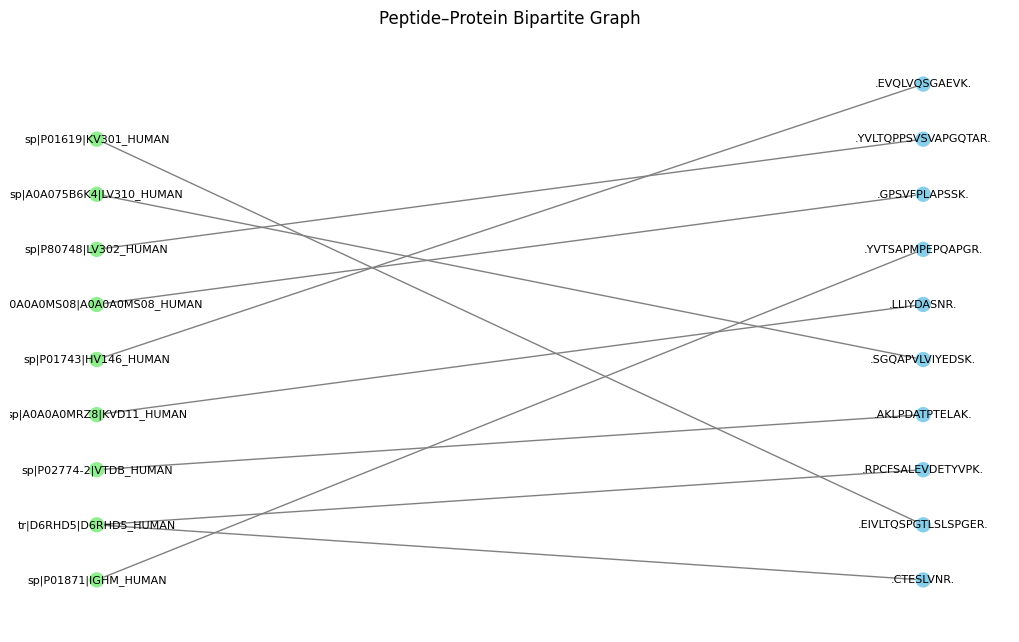

{'sp|P01871|IGHM_HUMAN', 'tr|D6RHD5|D6RHD5_HUMAN', 'sp|P02774-2|VTDB_HUMAN', 'sp|A0A0A0MRZ8|KVD11_HUMAN', 'sp|P01743|HV146_HUMAN', 'tr|A0A0A0MS08|A0A0A0MS08_HUMAN', 'sp|P80748|LV302_HUMAN', 'sp|A0A075B6K4|LV310_HUMAN', 'sp|P01619|KV301_HUMAN'}


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create bipartite graph
G = nx.Graph()

# Add peptide and protein nodes
peptides = set(graph_pep2pro.keys())
proteins = set(graph_pro2pep.keys())

G.add_nodes_from(peptides, bipartite=0, label='peptide')
# G.add_nodes_from(proteins, bipartite=1, label='protein')
G.add_nodes_from(selected_proteins, bipartite=1, label='protein')

pepset = set()
for pro, peps in graph_pro2pep.items():
    if pro in selected_proteins:
        pepset.update(peps)
        for pep in peps:
            G.add_edge(pep, pro)
            pass
        print(f"Protein {pro} has {len(peps)} peptidoforms, selected {len(pepset)} peptidoforms so far.")

# Positioning for bipartite layout
from networkx.algorithms import bipartite

pos = dict()
pos.update((node, (2, i)) for i, node in enumerate(peptides))
pos.update((node, (1, i)) for i, node in enumerate(selected_proteins))

# Draw the graph
plt.figure(figsize=(10, 6))
node_colors = []
for node in G.nodes():
    if node in peptides:
        node_colors.append("skyblue")
    elif node in selected_proteins:
        node_colors.append("skyblue")
    else:
        node_colors.append("lightgreen")
nx.draw(G, pos, with_labels=True, node_color=["skyblue" if n in peptides else "lightgreen" for n in G.nodes()],
        edge_color="gray", node_size=100, font_size=8)

plt.title("Peptide–Protein Bipartite Graph")
plt.axis('off')
plt.tight_layout()
plt.show()
print(selected_proteins)

In [32]:
# Check the distribution of the selected proteins in the original dataframe
selected_proteins_df = main_df[main_df['Proteins'].apply(lambda x: any(pro in x for pro in selected_proteins))]
print(f"Selected proteins in the original dataframe: {len(selected_proteins_df)}")

Selected proteins in the original dataframe: 587


In [34]:
# for pro in selected_proteins:
#     print(f"Protein: {pro}, Peptidoforms: {graph_pro2pep[pro]}")
#     dist = 
patient_columns = ["Peptidoform", "Unmod peptidoform"] + [item for item in selected_proteins_df.columns if item.startswith('_dyn_#') and "unmod" not in item]
selected_proteins_df[patient_columns].head()

,Peptidoform,Unmod peptidoform,_dyn_#Patient_01.Timepoint_1,_dyn_#Patient_01.Timepoint_2,_dyn_#Patient_01.Timepoint_3,_dyn_#Patient_01.Timepoint_4,_dyn_#Patient_01.Timepoint_5,_dyn_#Patient_01.Timepoint_6,_dyn_#Patient_01.Timepoint_7,_dyn_#Patient_02.Timepoint_1,...,_dyn_#Patient_F3_healthyFemale.Timepoint_3,_dyn_#Patient_M1_healthyMale.Timepoint_1,_dyn_#Patient_M1_healthyMale.Timepoint_2,_dyn_#Patient_M1_healthyMale.Timepoint_3,_dyn_#Patient_M2_healthyMale.Timepoint_1,_dyn_#Patient_M2_healthyMale.Timepoint_2,_dyn_#Patient_M2_healthyMale.Timepoint_3,_dyn_#Patient_M3_healthyMale.Timepoint_1,_dyn_#Patient_M3_healthyMale.Timepoint_2,_dyn_#Patient_M3_healthyMale.Timepoint_3
23,.YVTSAPM+15.995PEPQAPGR.,.YVTSAPMPEPQAPGR.,"997,870,000","686,612,500","651,740,000","376,645,000","752,370,000","785,587,500","864,790,000","410,262,500",...,NaN,NaN,NaN,"36,653,000",NaN,NaN,NaN,NaN,NaN,NaN
61,.RPC-33.988FSALEVDETYVPK.,.RPCFSALEVDETYVPK.,"6,488,975,000","4,709,350,000","5,171,375,000","4,806,075,000","7,190,500,000","8,166,100,000","6,258,275,000","4,722,725,000",...,"7,249,500","22,243,000","141,660,000","208,870,000",NaN,NaN,NaN,NaN,NaN,NaN
97,.RPC+119.004FSALEVDETYVPK.,.RPCFSALEVDETYVPK.,"369,977,500","503,155,000","277,030,000","289,665,000","221,348,000","279,225,000","290,790,000","346,947,500",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,.EI-14.016VLTQSPGTLSLSPGER.,.EIVLTQSPGTLSLSPGER.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"311,145,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326,.EIVLTQSPGTLSLSPGE-14.016R.,.EIVLTQSPGTLSLSPGER.,"167,282,000","116,683,250","115,415,250","93,152,250","113,858,500","129,512,500","137,566,000","134,213,500",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
